# testing notebook

In [1]:
# from importlib import reload
# import sys
# reload(sys.modules["util.subject"])

# import pickle
import h5py
import numpy as np
import nibabel as nib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
from scipy.stats import zscore, pearsonr
from collections import defaultdict
from constants import *
from tqdm import tqdm
from util import subject, plot
from util.path import Path
from util.atlas import Atlas

from himalaya.scoring import correlation_score

# resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1e9

In [2]:
%cd ..

/scratch/gpfs/zzada/fconv


In [4]:
modelname = "model-gpt2-medium_layer-0.75"
modelname = "model-gpt2-xl_layer-0.75"

# confounds

In [8]:
dfc = pd.read_csv(
    "data/derivatives/fmriprep/sub-004/ses-1/func/sub-004_ses-1_task-Conv_run-1_desc-confounds_timeseries.tsv",
    sep="\t",
)
dfc

global_signal  global_signal_derivative1  global_signal_power2  \
0       569.907013                        NaN         324794.003480   
1       568.253162                  -1.653851         322911.655936   
2       567.307847                  -0.945314         321838.193800   
3       566.386234                  -0.921614         320793.365519   
4       565.453703                  -0.932531         319737.889914   
..             ...                        ...                   ...   
539     566.805889                   1.910770         321268.915650   
540     565.764147                  -1.041741         320089.070445   
541     564.529395                  -1.234752         318693.438123   
542     563.589802                  -0.939594         317633.464526   
543     563.574677                  -0.015125         317616.416658   

     global_signal_derivative1_power2         csf  csf_derivative1  \
0                                 NaN  461.384254              NaN   
1                            2.735224  458.160661        -3.223593   
2                            0.893619  458.781424         0.620763   
3                            0.849372  458.145425        -0.635999   
4                            0.869614  460.856568         2.711143   
..                                ...         ...              ...   
539                          3.651043  451.269663        -0.390862   
540                          1.085225  453.543934         2.274271   
541                          1.524613  453.138892        -0.405042   
542                          0.882836  451.810021        -1.328870   
543                          0.000229  453.276470         1.466449   

     csf_derivative1_power2     csf_power2  white_matter  \
0                       NaN  212875.429662    471.336074   
1                 10.391552  209911.191101    471.518095   
2                  0.385347  210480.394850    471.050123   
3                  0.404495  209897.230055    470.833943   
4                  7.350296  212388.775824    470.536263   
..                      ...            ...           ...   
539                0.152773  203644.308876    464.940267   
540                5.172307  205702.099829    464.583483   
541                0.164059  205334.855003    464.990958   
542                1.765896  204132.295211    464.537807   
543                2.150473  205459.558348    464.561949   

     white_matter_derivative1  ...  motion_outlier97  motion_outlier98  \
0                         NaN  ...               0.0               0.0   
1                    0.182021  ...               0.0               0.0   
2                   -0.467972  ...               0.0               0.0   
3                   -0.216180  ...               0.0               0.0   
4                   -0.297681  ...               0.0               0.0   
..                        ...  ...               ...               ...   
539                  0.849988  ...               0.0               0.0   
540                 -0.356783  ...               0.0               0.0   
541                  0.407475  ...               0.0               0.0   
542                 -0.453151  ...               0.0               0.0   
543                  0.024141  ...               0.0               0.0   

     motion_outlier99  motion_outlier100  motion_outlier101  \
0                 0.0                0.0                0.0   
1                 0.0                0.0                0.0   
2                 0.0                0.0                0.0   
3                 0.0                0.0                0.0   
4                 0.0                0.0                0.0   
..                ...                ...                ...   
539               0.0                0.0                0.0   
540               0.0                0.0                0.0   
541               0.0                0.0                0.0   
542               0.0                0.0                0.0   
543     

In [9]:
dfc[[c for c in dfc.columns if c.startswith('motion')]]

motion_outlier00  motion_outlier01  motion_outlier02  motion_outlier03  \
0                 0.0               0.0               0.0               0.0   
1                 0.0               0.0               0.0               0.0   
2                 0.0               0.0               0.0               0.0   
3                 0.0               0.0               0.0               0.0   
4                 0.0               0.0               0.0               0.0   
..                ...               ...               ...               ...   
539               0.0               0.0               0.0               0.0   
540               0.0               0.0               0.0               0.0   
541               0.0               0.0               0.0               0.0   
542               0.0               0.0               0.0               0.0   
543               0.0               0.0               0.0               0.0   

     motion_outlier04  motion_outlier05  motion_outlier06  motion_outlier07  \
0                 0.0               0.0               0.0               0.0   
1                 0.0               0.0               0.0               0.0   
2                 0.0               0.0               0.0               0.0   
3                 0.0               0.0               0.0               0.0   
4                 0.0               0.0               0.0               0.0   
..                ...               ...               ...               ...   
539               0.0               0.0               0.0               0.0   
540               0.0               0.0               0.0               0.0   
541               0.0               0.0               0.0               0.0   
542               0.0               0.0               0.0               0.0   
543               0.0               0.0               0.0               0.0   

     motion_outlier08  motion_outlier09  ...  motion_outlier97  \
0                 0.0               0.0  ...               0.0   
1                 0.0               0.0  ...               0.0   
2                 0.0               0.0  ...               0.0   
3                 0.0               0.0  ...               0.0   
4                 0.0               0.0  ...               0.0   
..                ...               ...  ...               ...   
539               0.0               0.0  ...               0.0   
540               0.0               0.0  ...               0.0   
541               0.0               0.0  ...               0.0   
542               0.0               0.0  ...               0.0   
543               0.0               0.0  ...               0.0   

     motion_outlier98  motion_outlier99  motion_outlier100  motion_outlier101  \
0                 0.0               0.0                0.0                0.0   
1                 0.0               0.0                0.0                0.0   
2                 0.0               0.0                0.0                0.0   
3                 0.0               0.0                0.0                0.0   
4                 0.0               0.0                0.0                0.0   
..                ...               ...                ...                ...   
539               0.0               0.0                0.0                0.0   
540               0.0               0.0                0.0                0.0   
541               0.0               0.0                0.0                0.0   
542               0.0               0.0                0.0                0.0   
543               0.0               0.0                0.0                0.0   

     motion_outlier102  motion_outlier103  motion_outlier104  \
0                  0.0                0.0                0.0   
1                  0.0                0.0                0.0   
2                  0.0                0.0                0.0   
3                  0.0                0.0                0.0   
4                  0.

In [35]:
dfc[[c for c in dfc.columns if "derivative" in c]]

global_signal_derivative1  global_signal_derivative1_power2  \
0                          NaN                               NaN   
1                    -2.570452                          6.607224   
2                    -0.729344                          0.531943   
3                    -0.302875                          0.091733   
4                     1.126057                          1.268005   
..                         ...                               ...   
539                   1.908504                          3.642386   
540                   0.688012                          0.473361   
541                   0.669807                          0.448642   
542                  -0.379579                          0.144080   
543                  -1.895024                          3.591117   

     csf_derivative1  csf_derivative1_power2  white_matter_derivative1  \
0                NaN                     NaN                       NaN   
1          -3.877555               15.035434                 -0.440503   
2          -0.992962                0.985974                 -0.234088   
3          -0.543053                0.294907                 -0.387425   
4          -0.683488                0.467156                  0.833287   
..               ...                     ...                       ...   
539         3.055788                9.337842                  0.653042   
540         1.556427                2.422464                  0.487740   
541         1.461701                2.136571                  0.038760   
542         1.474351                2.173710                  0.477533   
543        -3.787717               14.346801                 -0.101308   

     white_matter_derivative1_power2  trans_x_derivative1  \
0                                NaN                  NaN   
1                           0.194043            -0.000658   
2                           0.054797            -0.000632   
3                           0.150098             0.007651   
4                           0.694367            -0.022792   
..                               ...                  ...   
539                         0.426464             0.007285   
540                         0.237891            -0.027113   
541                         0.001502            -0.015232   
542                         0.228038            -0.000577   
543                         0.010263            -0.001153   

     trans_x_derivative1_power2  trans_y_derivative1  \
0                           NaN                  NaN   
1                  4.332272e-07             0.016124   
2                  3.994240e-07            -0.043405   
3                  5.853933e-05             0.008397   
4                  5.194661e-04            -0.000046   
..                          ...                  ...   
539                5.306831e-05             0.005779   
540                7.351365e-04             0.060325   
541                2.320138e-04            -0.057304   
542                3.335062e-07             0.069671   
543                1.329640e-06            -0.136801   

     trans_y_derivative1_power2  trans_z_derivative1  \
0                           NaN                  NaN   
1                  2.599963e-04             0.039534   
2                  1.884029e-03             0.069097   
3                  7.050625e-05             0.024975   
4                  2.116000e-09            -0.011567   
..                          ...                  ...   
539                3.339684e-05            -0.099750   
540                3.639106e-03             0.081580   
541                3.283748e-03             0.132610   
542                4.854048e-03            -0.074900   
543                1.871449e-02             0.035760   

     trans_z_derivative1_power2  rot_x_derivative1  rot_x_derivative1_power2  \
0                           NaN                NaN                       NaN   
1                      0.001563           0.000823          

# fwdisp

In [8]:
results = defaultdict(list)

for sub in tqdm(SUBS_STRANGERS):
    # correlation between BOLD and fwdisp
    data, fsdisp = subject.get_bold(
        sub, return_cofounds=["framewise_displacement"], use_cache=True
    )
    _, switches = subject.get_button_presses(sub)
    prod_maskB = switches.astype(bool)
    comp_maskB = np.logical_not(prod_maskB)

    fsdisp = fsdisp[:, -1:]

    results["prod_scores"].append(
        correlation_score(data[prod_maskB], fsdisp[prod_maskB])
    )
    results["comp_scores"].append(
        correlation_score(data[comp_maskB], fsdisp[comp_maskB])
    )
    results["prod_disp"].append(fsdisp[prod_maskB].mean())
    results["comp_disp"].append(fsdisp[comp_maskB].mean())

prod_disp = np.array(results["prod_disp"])
comp_disp = np.array(results["comp_disp"])
prod_scores = np.array(results["prod_scores"])
comp_scores = np.array(results["comp_scores"])
prod_disp.shape

100%|██████████| 58/58 [01:30<00:00,  1.56s/it]


(58,)

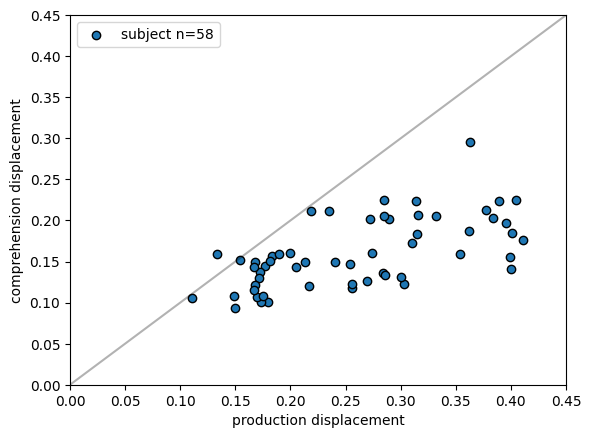

In [6]:
plt.scatter(
    prod_disp, comp_disp, label=f"subject n={len(prod_disp)}", edgecolors="black"
)
plt.axline(xy1=(0, 0), slope=1, alpha=0.3, color="k")
plt.xlim(0, 0.45)
plt.ylim(0, 0.45)
plt.xlabel("production displacement")
plt.ylabel("comprehension displacement")
plt.legend()
plt.show()

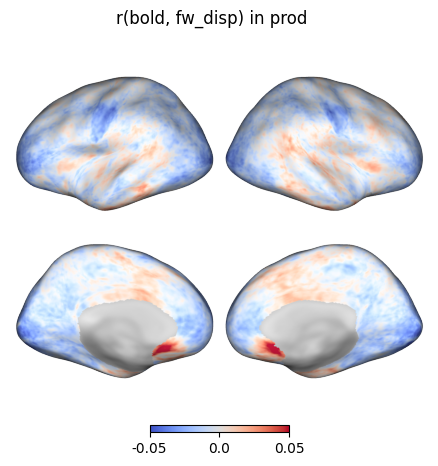

In [37]:
# how correlated are voxels to FWdisplacement during production?
values = np.mean(prod_scores, axis=0)
fig = plot.surface_plot(values, title="r(bold, fw_disp) in prod")

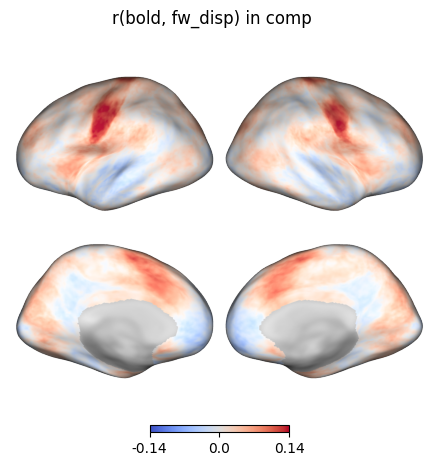

In [66]:
values = np.mean(comp_scores, axis=0)
fig = plot.surface_plot(values, title="r(bold, fw_disp) in comp")

## single subject

In [4]:
# find a good/bad subject
atlas = Atlas.schaefer2018(100)
roiname = '17Networks_LH_SomMotB_Cent_1'
roimask = atlas.label_img == atlas[roiname]
# comp_scores[:, roimask].max(-1).argmax()

In [5]:
sub = 107
sub = 163
sub = 29
# subid = SUBS_STRANGERS.index(sub)
# SUBS_STRANGERS[subid], comp_disp[subid], comp_scores[subid].max()

In [6]:
_, switches = subject.get_button_presses(sub)
prod_mask = switches.astype(bool)
comp_mask = np.logical_not(prod_mask)

In [7]:
core_motions = ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z',]
extra_motions = MOTION_CONFOUNDS[:-1]
motions = ['motion_outlier00']

PearsonRResult(statistic=0.07321209625994188, pvalue=0.01118378247511501)
PearsonRResult(statistic=-0.059052766612900834, pvalue=0.1458421623222487)
PearsonRResult(statistic=0.1833687755010609, pvalue=7.113871156397939e-06)


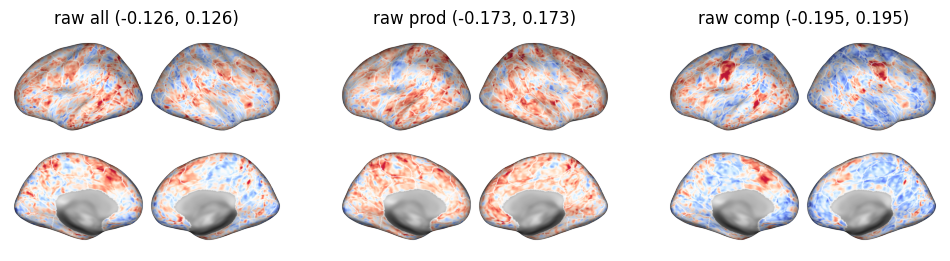

In [17]:
# no motion regression
data, fwd = subject.get_bold(sub, motion_confounds=motions, return_confounds=['framewise_displacement'], use_cache=False)
# data, fwd = subject.get_bold(sub, return_cofounds=['framewise_displacement'])

raw_corrs = correlation_score(data, fwd)
raw_prod_corrs = correlation_score(data[prod_mask], fwd[prod_mask])
raw_comp_corrs = correlation_score(data[comp_mask], fwd[comp_mask])

somato = data[:, roimask].mean(-1)
print(pearsonr(fwd[:,0], somato))
print(pearsonr(fwd[prod_mask,0], somato[prod_mask]))
print(pearsonr(fwd[comp_mask,0], somato[comp_mask]))

fig, axes = plt.subplots(1, 3, figsize=(12, 6))
plot.surface_plot(raw_corrs,      title='raw all', atlas=atlas , fig=fig, ax=axes[0], cbar=False)
plot.surface_plot(raw_prod_corrs, title='raw prod', atlas=atlas, fig=fig, ax=axes[1], cbar=False)
plot.surface_plot(raw_comp_corrs, title='raw comp', atlas=atlas, fig=fig, ax=axes[2], cbar=False)
fig.show()

PearsonRResult(statistic=0.025990588445679287, pvalue=0.36835762247429904)
PearsonRResult(statistic=-0.006277207187584078, pvalue=0.8714516816604044)
PearsonRResult(statistic=0.11924541127263621, pvalue=0.005844652190318815)


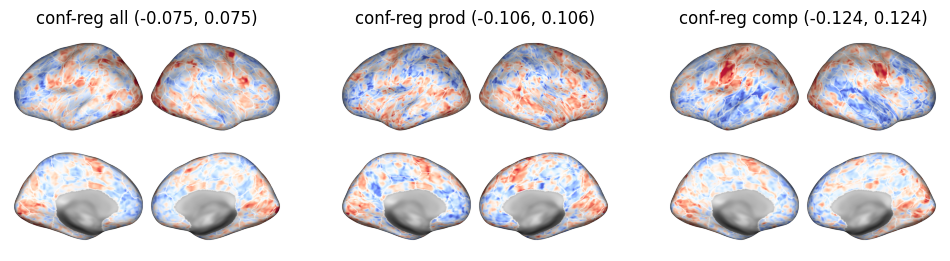

In [30]:
# motion regression on run level but not split into prod/comp
data = subject.get_bold(sub, motion_confounds=motions, mri_confounds=MOTION_CONFOUNDS + CONFOUND_REGRESSORS)

creg_corrs = correlation_score(data, fwd)
creg_prod_corrs = correlation_score(data[prod_mask], fwd[prod_mask])
creg_comp_corrs = correlation_score(data[comp_mask], fwd[comp_mask])

somato = data[:, roimask].mean(-1)
print(pearsonr(fwd[:,0], somato))
print(pearsonr(fwd[prod_mask,0], somato[prod_mask]))
print(pearsonr(fwd[comp_mask,0], somato[comp_mask]))

fig, axes = plt.subplots(1, 3, figsize=(12, 6))
plot.surface_plot(creg_corrs,      title='conf-reg all', atlas=atlas , fig=fig, ax=axes[0], cbar=False)
plot.surface_plot(creg_prod_corrs, title='conf-reg prod', atlas=atlas, fig=fig, ax=axes[1], cbar=False)
plot.surface_plot(creg_comp_corrs, title='conf-reg comp', atlas=atlas, fig=fig, ax=axes[2], cbar=False)
fig.show()

PearsonRResult(statistic=0.0018308361223832378, pvalue=0.94948303927143)
PearsonRResult(statistic=0.0015976635975504744, pvalue=0.9686403673495599)
PearsonRResult(statistic=0.003606866222781658, pvalue=0.9302155492846823)


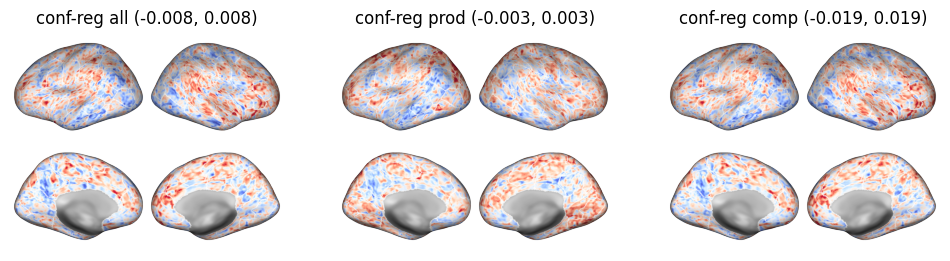

In [19]:
# motion regression on trial level and split for prod/comp
data = subject.get_bold(sub)

creg_corrs = correlation_score(data, fwd)
creg_prod_corrs = correlation_score(data[prod_mask], fwd[prod_mask])
creg_comp_corrs = correlation_score(data[comp_mask], fwd[comp_mask])

somato = data[:, roimask].mean(-1)
print(pearsonr(fwd[:,0], somato))
print(pearsonr(fwd[prod_mask,0], somato[prod_mask]))
print(pearsonr(fwd[comp_mask,0], somato[comp_mask]))

fig, axes = plt.subplots(1, 3, figsize=(12, 6))
plot.surface_plot(creg_corrs,      title='conf-reg all', atlas=atlas , fig=fig, ax=axes[0], cbar=False)
plot.surface_plot(creg_prod_corrs, title='conf-reg prod', atlas=atlas, fig=fig, ax=axes[1], cbar=False)
plot.surface_plot(creg_comp_corrs, title='conf-reg comp', atlas=atlas, fig=fig, ax=axes[2], cbar=False)
fig.show()

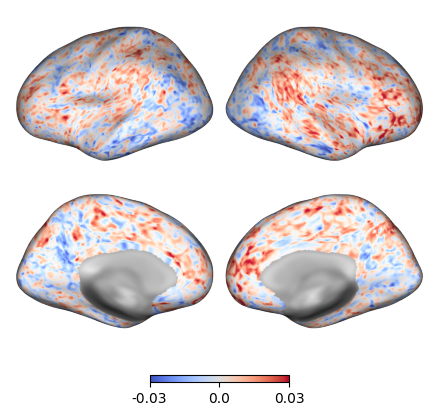

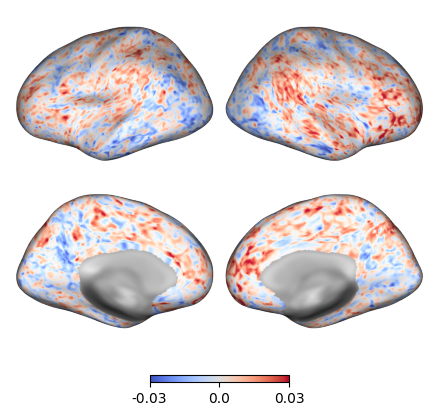

In [20]:
trial_data = np.split(data, 10, axis=0)
trial_mask = np.split(comp_mask, 10)
trial_fwd = np.split(fwd, 10)

trial_scores = [correlation_score(d[m], f[m]) for d, f, m in zip(trial_data, trial_fwd, trial_mask)]
full_scores = np.mean(trial_scores, axis=0)

plot.surface_plot(full_scores);

## i knew you were black

In [65]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

In [66]:
subs = list(CONVS_STRANGERS) + [c - 100 for c in CONVS_STRANGERS]
# these subjects didn't do listen to this story, not sure why
subs.remove(11)
subs.remove(111)
subs.remove(12)

corrs, disps = [], []
for sub in tqdm(subs):

    boldpath = Path(
        root="data/derivatives/fmriprep/",
        datatype="func",
        sub="004",
        ses=1,
        task="Black",
        run=1,
        space="fsaverage6",
        hemi="L",
        suffix="bold",
        ext=".func.gii",
    )
    boldpath.update(sub=f"{sub:03d}")

    paths = [boldpath, boldpath.copy().update(hemi="R")]

    confpath = Path(
        root="data/derivatives/fmriprep/",
        sub="004",
        ses=1,
        datatype="func",
        task="Black",
        run=1,
        desc="confounds",
        suffix="timeseries",
        ext=".tsv",
    )
    confpath.update(sub=f"{sub:03d}")

    confdata = pd.read_csv(confpath, sep="\t", usecols=CONFOUNDS)
    confdata.bfill(inplace=True)

    masker = subject.GiftiMasker(
        t_r=TR,
        ensure_finite=True,
        standardize="zscore_sample",
        standardize_confounds=True,
    )
    data = masker.fit_transform(paths, confounds=confdata.to_numpy())
    fdisp = (
        pd.read_csv(confpath, sep="\t", usecols=["framewise_displacement"])
        .fillna(value=0)
        .to_numpy()
    )

    corrs.append(correlation_score(data, fdisp))
    disps.append(fdisp)

100%|██████████| 55/55 [05:40<00:00,  6.20s/it]


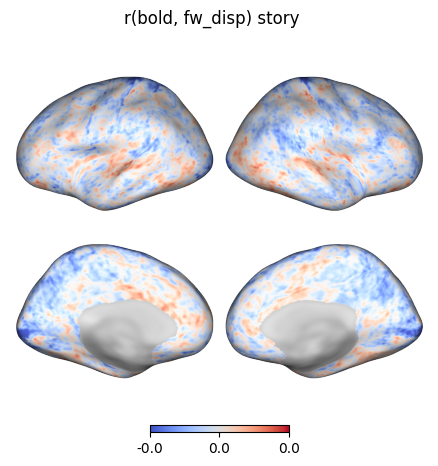

In [70]:
values = np.mean(corrs, axis=0)
fig = plot.surface_plot(values, title="r(bold, fw_disp) story", vmax=0.002)

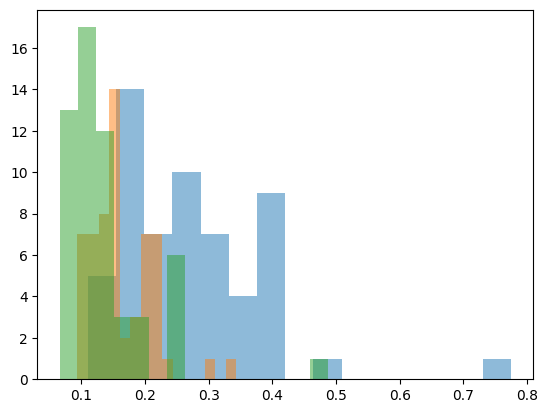

In [78]:
plt.hist(prod_disp, bins=15, alpha=0.5, label="prod")
plt.hist(comp_disp, bins=15, alpha=0.5, label="comp")
plt.hist(dd, bins=15, alpha=0.5, label="story")

/scratch/gpfs/zzada/conda-envs/fconv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/gpfs/zzada/conda-envs/fconv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

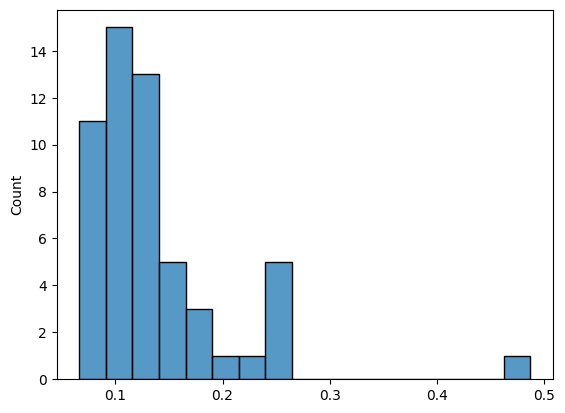

In [75]:
dd = np.stack(disps).mean((1, 2))
sns.histplot(dd)

# Encoding

In [10]:
import sys
from importlib import reload
# reload(sys.modules["util.subject"])
reload(sys.modules["encoding"])

import encoding as enc

## regressors

In [11]:
sub = 104
X, features = enc.build_regressors(sub, modelname="model-gpt2-medium_layer-0.75")
X.shape, features

((1200, 2311),
 {'task': slice(0, 9, None),
  'spectral': slice(9, 169, None),
  'articulation': slice(169, 213, None),
  'motion': slice(213, 263, None),
  'prod_semantic': slice(263, 1287, None),
  'comp_semantic': slice(1287, 2311, None)})

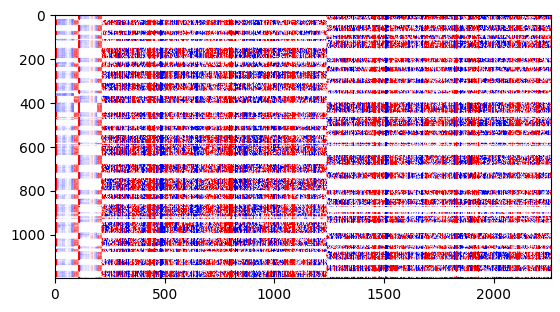

In [87]:
plt.imshow(X[:], vmin=-1, vmax=1, cmap="bwr")

In [88]:
plt.imshow(
    X[:120, features["spectral"]].T, cmap="viridis", interpolation=None
    # X[:120, features["articulation"]].T, cmap="viridis", interpolation=None
)

KeyError: 'spectral'

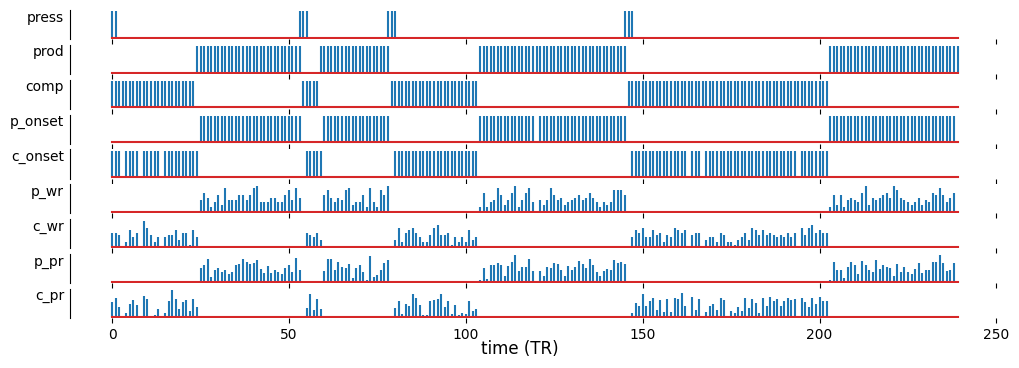

In [34]:
slc = slice(0, 240)
# slc = slice(960, 1200)
names = ["press", "prod", "comp", "p_onset", "c_onset", "p_wr", "c_wr", "p_pr", "c_pr"]
fig, axes = plt.subplots(len(names), 1, figsize=(12, 4), sharex=True)
for i, ax in enumerate(axes):
    ax.stem(X[slc, i], markerfmt="")
    # ax.plot(X[slc, i])
    ax.spines[["right", "top", "bottom"]].set_visible(False)
    ax.set_ylabel(names[i], rotation=0, horizontalalignment="right")
    ax.get_yaxis().set_ticks([])
    ax.spines[["right", "top", "bottom"]].set_visible(False)
fig.supxlabel("time (TR)")
fig.show()

In [12]:
feature_names = list(features.keys())
slices = list(features.values())
pipeline = enc.build_model(feature_names, slices, [], 0, 0)
pipeline

Pipeline(steps=[('columnkernelizer',
                 ColumnKernelizer(n_jobs=0,
                                  transformers=[('task',
                                                 Pipeline(steps=[('splitdelayer',
                                                                  SplitDelayer(delays=[2,
                                                                                       3,
                                                                                       4,
                                                                                       5])),
                                                                 ('kernelizer',
                                                                  Kernelizer())]),
                                                 slice(0, 9, None)),
                                                ('spectral',
                                                 Pipeline(steps=[('standardscaler',
                                                                  StandardScaler(with_std=False)),
                                                                 ('splitdelayer',
                                                                  SplitDelayer(delays=[2,
                                                                                       3,
                                                                                       4,
                                                                                       5])),
                                                                 ('kernelizer',
                                                                  Kernelizer())])...
                                                 slice(263, 1287, None)),
                                                ('comp_semantic',
                                                 Pipeline(steps=[('standardscaler',
                                                                  StandardScaler(with_std=False)),
                                                                 ('splitdelayer',
                                                                  SplitDelayer(delays=[2,
                                                                                       3,
                                                                                       4,
                                                                                       5])),
                                                                 ('kernelizer',
                                                                  Kernelizer())]),
                                                 slice(1287, 2311, None))])),
                ('multiplekernelridgecv',
                 MultipleKernelRidgeCV(kernels='precomputed',
                                       solver_params={'alphas': [],
                                                      'diagonalize_method': 'svd',
                                                      'n_iter': 100,
                                                      'progress_bar': 0}))])

### epochs

In [81]:
data, conf = subject.get_bold(
    sub, return_cofounds=["framewise_displacement"], use_cache=True
)
data.shape

(1200, 81924)

In [41]:
def build_epochs(
    values: np.ndarray, onsets: np.ndarray, tmin: int = 5, tmax: int = 5
) -> np.ndarray:
    epochs = []
    for onset in onsets:
        start, end = onset - tmin, onset + tmax
        if start > 0 and end < values.size:
            epochs.append(values[start : end + 1])
    return np.stack(epochs).squeeze()

In [9]:
epochs = []
for sub in tqdm(SUBS_STRANGERS):
    X, _ = enc.build_regressors(sub, modelname="model-gpt2-medium_layer-0.75")
    _, conf = subject.get_bold(
        sub, return_cofounds=["framewise_displacement"], use_cache=True
    )
    # events, label = X[:, 0].nonzero()[0], 'button press'
    # events, label = (np.diff(X[:, 1]) > 0).nonzero()[0], 'comp -> prod'
    events, label = (np.diff(X[:, 1]) < 0).nonzero()[0], "prod -> comp"
    epochs.append(build_epochs(conf, events))
epochs = np.vstack(epochs)
epochs.shape

100%|██████████| 58/58 [02:49<00:00,  2.91s/it]


(1448, 10)

In [65]:
tmin, tmax = 5, 5
# events, label = X[:, 0].nonzero()[0], 'button press'
events, label = (np.diff(X[:, 1]) > 0).nonzero()[0], "comp -> prod"
# events, label = (np.diff(X[:, 1]) < 0).nonzero()[0], 'prod -> comp'
epochs = build_epochs(conf, events)
epochs.shape

(33, 10)

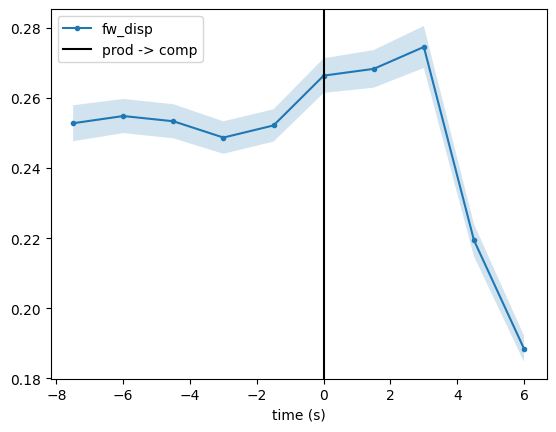

In [94]:
xaxis = np.arange(-tmin, tmax) * TR
mean = np.mean(epochs, 0).squeeze()
err = np.std(epochs, 0).squeeze() / np.sqrt(epochs.shape[0])
plt.plot(xaxis, mean, label="fw_disp", marker=".")
plt.fill_between(xaxis, mean - err, mean + err, alpha=0.2)
plt.axvline(0, c="k", label=label)
plt.xlabel("time (s)")
plt.legend(loc="best")
plt.show()

### time series

In [91]:
c_vox = 705
conf = fwd

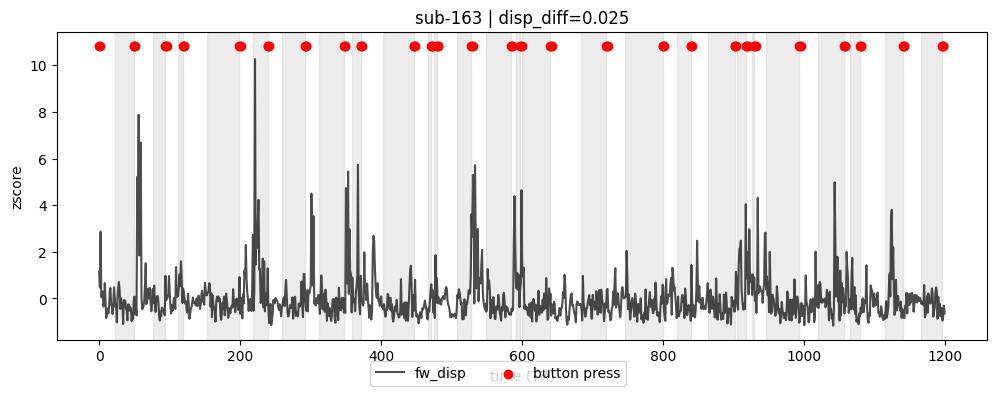

In [93]:
fig, ax = plt.subplots(figsize=(12, 4))

switches = [0] + np.nonzero(np.diff(X[:, 1]))[0].tolist()
for i in range(1, len(switches)):
    if i % 2 == 0:
        ax.axvspan(switches[i - 1], switches[i], color="gray", alpha=0.15, zorder=1)

ax.plot(zscore(conf), c="k", label="fw_disp", alpha=0.7, zorder=2)

presses = X[:, 0].nonzero()[0]
ax.scatter(
    presses,
    np.ones_like(presses) * ax.get_ylim()[1],
    c="red",
    label="button press",
    zorder=3,
)

# r = pearsonr(data[:, c_vox], conf.squeeze()).statistic
# ax.plot(
#     zscore(data[:, c_vox]), c="blue", zorder=4, alpha=0.5, label=f"voxel, r={r:.3f}"
# )
# ax.plot(zscore(data[:, p_vox]), c='green', zorder=4,  alpha=0.5)
# ax.set_xlim(0, 240)
# ax.set_xlim(960, 1200)

compd = conf[X[:, 1] == 0].mean()
prodd = conf[X[:, 1] == 1].mean()
ax.set(
    ylabel="zscore",
    xlabel="time (TR)",
    title=f"sub-{sub:03d} | disp_diff={compd-prodd:.3f}",
)

fig.legend(loc="lower center", ncol=3, alignment="left")
fig.show()

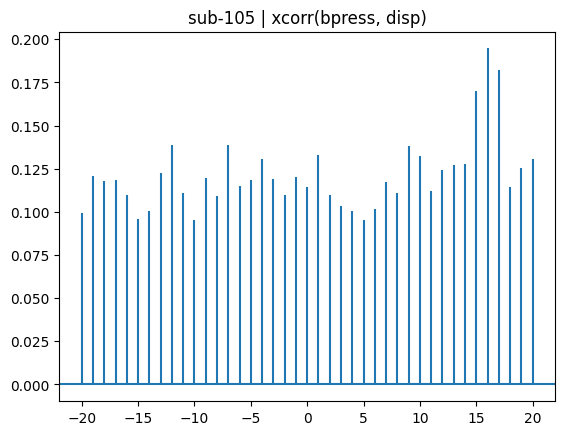

In [147]:
plt.title(f"sub-{sub:03d} | xcorr(bpress, disp)")
plt.xcorr(X[:, 0], conf.squeeze(), maxlags=20)
plt.show()

In [15]:
with open(
    f"encoding/sub-{sub:03d}/model-gpt2-medium_layer-0.75/sub-{sub:03d}.pkl", "rb"
) as f:
    ds = pickle.load(f)
ds.keys()

dict_keys(['cv_scores', 'cv_scores_prod', 'cv_scores_comp', 'cv_alphas', 'cv_preds', 'in_prod', 'in_comp', 'cv_models'])

In [16]:
preds = np.stack(ds["cv_preds"])
preds = np.swapaxes(preds, 0, 1).reshape(5, 1200, -1)
preds.shape

(5, 1200, 81924)

In [17]:
scores = np.stack(ds["cv_scores"]).mean(0)
print(scores.shape)
print(scores.max(-1))
print(scores.argmax(-1))

(5, 81924)
[0.34522906 0.2472285  0.13502821 0.3223776  0.36159092]
[ 5544 34602 38227 77042 66705]


In [21]:
voxid = 212
voxid = 66705

for score, feature in zip(scores[:, voxid].round(4), features):
    print(feature, score)

nuisance 0.0134
wp_rate 1e-04
phonemes 0.0023
production -0.0294
comprehension 0.3616


In [22]:
fnames = list(features.keys())
features

{'nuisance': slice(0, 4, None),
 'wp_rate': slice(4, 8, None),
 'phonemes': slice(8, 86, None),
 'production': slice(86, 1110, None),
 'comprehension': slice(1110, 2134, None)}

nuisance
wp_rate
phonemes
production
comprehension


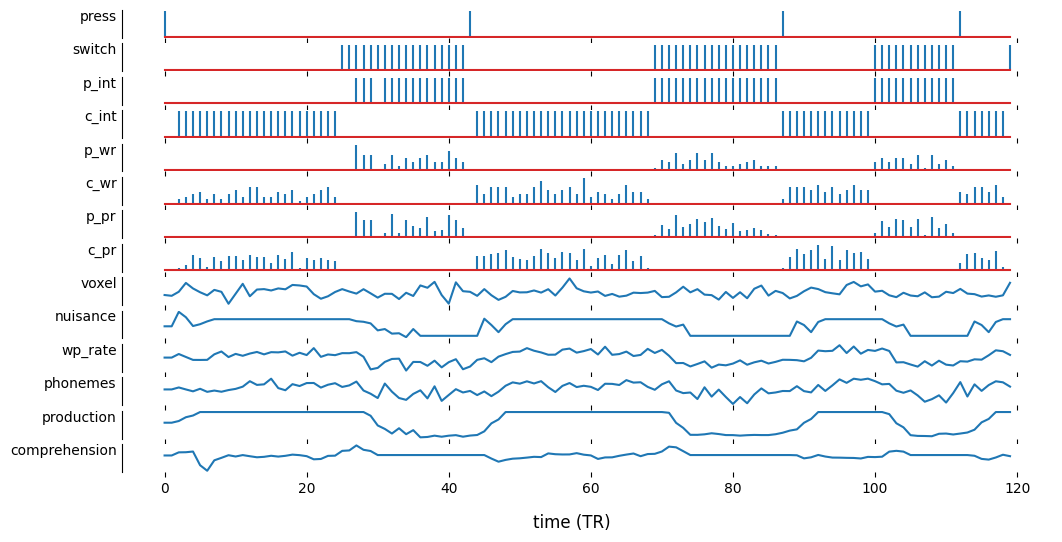

In [23]:
slc = slice(0, 120)

names = ["press", "switch", "p_int", "c_int", "p_wr", "c_wr", "p_pr", "c_pr"]
fig, axes = plt.subplots(14, 1, figsize=(12, 6), sharex=True)
for i, ax in enumerate(axes):
    ax.stem(X[slc, i], markerfmt="")
    ax.set_ylabel(names[i], rotation=0, horizontalalignment="right")
    if i == len(names) - 1:
        break

# plot actuals
i += 1
axes[i].plot(data[slc, voxid])
axes[i].set_ylabel("voxel", rotation=0, horizontalalignment="right")

# plot predictions
i += 1
for j in range(len(fnames)):
    axes[i + j].plot(preds[j, slc, voxid])
    axes[i + j].set_ylabel(fnames[j], rotation=0, horizontalalignment="right")

for ax in axes:
    ax.get_yaxis().set_ticks([])
    ax.spines[["right", "top", "bottom"]].set_visible(False)

fig.supxlabel("time (TR)")
fig.show()

In [24]:
print(pearsonr(data[:, voxid], conf[:, 0]))
for i in range(len(fnames)):
    print(fnames[i], pearsonr(preds[i, :, voxid], conf[:, 0]))

PearsonRResult(statistic=0.03832875652260853, pvalue=0.1845580089315461)
nuisance PearsonRResult(statistic=-0.04638223433142109, pvalue=0.10829202445347391)
wp_rate PearsonRResult(statistic=0.014819012680032294, pvalue=0.6080640687289771)
phonemes PearsonRResult(statistic=-0.022266446655133682, pvalue=0.4409298195192763)
production PearsonRResult(statistic=-0.026646696618731956, pvalue=0.3563875413131502)
comprehension PearsonRResult(statistic=-0.0317007889548526, pvalue=0.27251950706182226)


In [25]:
in_prod = ds["in_prod"]
in_comp = ds["in_comp"]

In [26]:
print("brain prod", pearsonr(data[in_prod, voxid], conf[in_prod, 0]).statistic)
print("brain comp", pearsonr(data[in_comp, voxid], conf[in_comp, 0]).statistic)
for i in range(len(fnames)):
    print(
        fnames[i],
        "prod",
        pearsonr(preds[i, in_prod, voxid], conf[in_prod, 0]).statistic,
    )
    print(
        fnames[i],
        "comp",
        pearsonr(preds[i, in_comp, voxid], conf[in_comp, 0]).statistic,
    )

brain prod -0.1519735479556865
brain comp 0.08151688241588999
nuisance prod -0.12887125740460856
nuisance comp -0.04405920408354318
wp_rate prod -0.1807661330389368
wp_rate comp 0.09121537042188309
phonemes prod -0.015994738573722325
phonemes comp 0.023811248454955965
production prod -0.16658235630362866
production comp -0.028097373687663466
comprehension prod -0.008090506558533715
comprehension comp -0.010644344053287184


## model

In [44]:
feature_names = list(features.keys())
slices = list(features.values())

In [47]:
pipeline = enc.build_model(feature_names, slices, np.linspace(0, 1, 10), 0, 1)
pipeline

Pipeline(steps=[('columnkernelizer',
                 ColumnKernelizer(n_jobs=1,
                                  transformers=[('nuissance',
                                                 Pipeline(steps=[('standardscaler',
                                                                  StandardScaler(with_std=False)),
                                                                 ('delayer',
                                                                  Delayer(delays=[2,
                                                                                  3,
                                                                                  4,
                                                                                  5])),
                                                                 ('kernelizer',
                                                                  Kernelizer())]),
                                                 slice(0, 3, None)),
                                                ('producton',
                                                 Pipeline(steps=[('standardscaler',
                                                                  StandardScaler(with_std=False)),
                                                                 ('delayer',
                                                                  Delayer(delays=[2,
                                                                                  3,...
                                                                  StandardScaler(with_std=False)),
                                                                 ('delayer',
                                                                  Delayer(delays=[2,
                                                                                  3,
                                                                                  4,
                                                                                  5])),
                                                                 ('kernelizer',
                                                                  Kernelizer())]),
                                                 slice(1027, 2051, None))])),
                ('caster', Caster()),
                ('multiplekernelridgecv',
                 MultipleKernelRidgeCV(kernels='precomputed',
                                       solver_params={'alphas': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
                                                      'progress_bar': 0}))])

# ISC

In [101]:
from encoding import build_regressors, SplitDelayer
from sklearn.linear_model import LinearRegression
from nilearn.glm.first_level import glover_hrf
from scipy.ndimage import convolve1d

In [6]:
atlas = Atlas.schaefer2018()
atlas = Atlas.schaefer2018(rois=100)
# atlas = Atlas.glasser2016()
len(atlas)

100

In [28]:
lags = [1, 2, 3, 4]
delayer = SplitDelayer(delays=[2, 3, 4, 5])
scores = defaultdict(list)

hrf = glover_hrf(TR, oversampling=1, time_length=32)

for subA in tqdm(SUBS_STRANGERS[:28]):
    subB = subject.get_partner(subA)

    xA, features = build_regressors(subA, modelname)
    xB, features = build_regressors(subB, modelname)

    nuisA = xA[:, features["nuisance"]]
    nuisB = xB[:, features["nuisance"]]
    nuisA = convolve1d(nuisA, hrf, axis=0, mode="constant", origin=-(hrf.size // 2))
    nuisB = convolve1d(nuisB, hrf, axis=0, mode="constant", origin=-(hrf.size // 2))

    dataA = subject.get_bold(subA, use_cache=True)
    dataB = subject.get_bold(subB, use_cache=True)

    dataA = atlas.vox_to_parc(dataA)
    dataB = atlas.vox_to_parc(dataB)

    modelA = LinearRegression().fit(nuisA, dataA)
    modelB = LinearRegression().fit(nuisB, dataB)

    resA = dataA - modelA.predict(nuisA)
    resB = dataB - modelB.predict(nuisB)
    # resA, resB = dataA, dataB

    # prodmaskA = xA[:, 1].astype(bool)
    prodmaskA = delayer.fit_transform(xA[:, 1:2]).any(-1)

    for i in range(0, 1200, 240):
        runmask = slice(i, i + 240)

        residA = resA[runmask]
        residB = resB[runmask]
        brainA = dataA[runmask]
        brainB = dataB[runmask]

        scores[0].append(
            correlation_score(residA[prodmaskA[runmask]], residB[prodmaskA[runmask]])
        )
        scores[1].append(correlation_score(residA, residB))
        scores[2].append(
            correlation_score(brainA[prodmaskA[runmask]], brainB[prodmaskA[runmask]])
        )
        scores[3].append(correlation_score(brainA, brainB))

    # scores[1].append(correlation_score(resA[prodmaskA][:-1], resB[prodmaskA][1:]))
    # scores[-1].append(correlation_score(resA[prodmaskA][1:], resB[prodmaskA][:-1]))

100%|██████████| 28/28 [03:15<00:00,  7.00s/it]


In [35]:
lag = 1
values = np.mean(scores[lag], axis=0)
voxes = values
voxes = atlas.parc_to_vox(values)
voxes.max(), voxes.shape

(0.09720854380447713, (81924,))

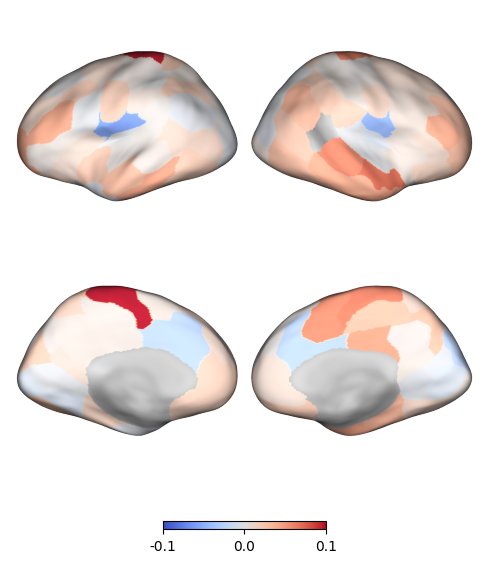

In [36]:
values = voxes
p = plot.get_surfplot(size=(600, 600), zoom=1.2)
p.add_layer(values, cmap="coolwarm", color_range=(-0.1, 0.1))
fig = p.build()
fig.show()

In [39]:
r = 125  # A5
r = 24  # A1
r = 9  # B3
mask = pmask == r
amax = np.argmax(scores[0][0] * mask)
amax, scores[0][0][amax]

(44975, 0.19197809336933677)

# intersubject MBC

In [99]:
from himalaya.scoring import correlation_score, correlation_score_split
from sklearn.model_selection import PredefinedSplit

In [135]:
atlass100 = Atlas.schaefer2018(1000)
atlassg = Atlas.glasser2016()

In [136]:
scores = defaultdict(list)
delayer = SplitDelayer(delays=[2, 3, 4, 5])

hrf = glover_hrf(TR, oversampling=1, time_length=32)

# use subA's predictions on subB's actual neural data
for subA in tqdm(SUBS_STRANGERS[:28]):
    # load subA preds
    encpath = Path(root="encoding", sub=f"{subA:03d}", datatype=modelname, ext=".hdf5")
    with h5py.File(encpath, "r") as f:
        Y_predsA = f["cv_preds"][...]
        predsA = np.stack([m[-2] for m in Y_predsA]).reshape(
            1200, -1
        )  # take prod predictions

    # load subB
    subB = subject.get_partner(subA)
    xB, features = build_regressors(subB, modelname)
    nuisB = xB[:, features["nuisance"]]
    nuisB = convolve1d(nuisB, hrf, axis=0, mode="constant", origin=-(hrf.size // 2))
    dataB = subject.get_bold(subB, use_cache=True)
    modelB = LinearRegression().fit(nuisB, dataB)
    resB = dataB - modelB.predict(nuisB)
    prodmaskA = delayer.fit_transform(xB[:, 2:3]).any(-1)

    scores[0].append(correlation_score(predsA[prodmaskA], resB[prodmaskA]))
    scores['sc100'].append(correlation_score(atlass100.vox_to_parc(predsA[prodmaskA]), atlass100.vox_to_parc(resB[prodmaskA])))
    scores['glass'].append(correlation_score(atlassg.vox_to_parc(predsA[prodmaskA]), atlassg.vox_to_parc(resB[prodmaskA])))
    # scores[1].append(correlation_score(predsA[prodmaskA][:-1], resB[prodmaskA][1:]))

100%|██████████| 28/28 [06:19<00:00, 13.54s/it]


In [129]:
glass = np.stack(scores['glass']).mean(0)
scaf = np.stack(scores['sc100']).mean(0)
voxel = np.stack(scores[0]).mean(0)

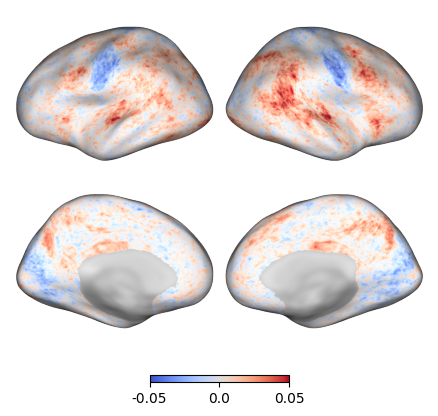

In [137]:
fig = plot.surface_plot(voxel)

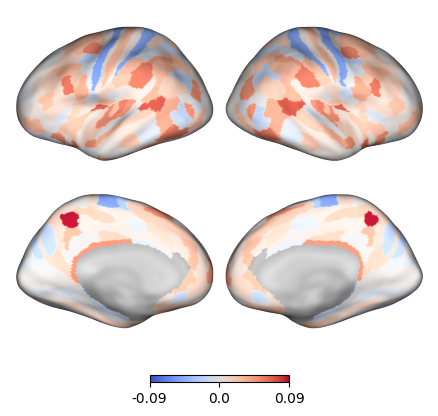

In [134]:
fig = plot.surface_plot(atlassg.parc_to_vox(glass[None, :]))

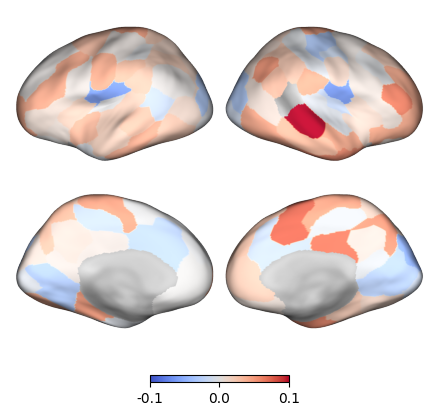

In [133]:
fig = plot.surface_plot(atlass100.parc_to_vox(scaf[None, :]))

In [10]:
# scores = []
scores_prod = []
scores_comp = []

run_ids = np.repeat(RUNS, CONV_TRS * 2)
kfold = PredefinedSplit(run_ids)

for subA in tqdm(SUBS_STRANGERS):
    subB = subject.get_partner(subA)
    dataA = subject.get_bold(subA, use_cache=True)

    # load encoding model
    encpath = Path(root="encoding", sub=f"{subB:03d}", datatype=modelname, ext=".pkl")
    with open(encpath, "rb") as f:
        ds = pickle.load(f)
        del ds["cv_models"]

    for k, (_, test_index) in enumerate(kfold.split()):
        Y_testA = dataA[test_index]
        Y_predsB = ds["cv_preds"][k]

        prod_maskB = ds["in_prod"][test_index]
        comp_maskB = ds["in_comp"][test_index]

        scores_prod.append(
            correlation_score(Y_testA[prod_maskB], Y_predsB[-2, prod_maskB])
        )
        scores_comp.append(
            correlation_score(Y_testA[comp_maskB], Y_predsB[-1, comp_maskB])
        )
        # scores.append(correlation_score_split(Y_test, Y_preds))

# scores = np.stack(scores).mean(0)
scores_prod = np.stack(scores_prod).mean(0)
scores_comp = np.stack(scores_comp).mean(0)
scores_prod.min(), scores_prod.max(), scores_comp.min(), scores_comp.max()

100%|██████████| 58/58 [03:30<00:00,  3.63s/it]


(-0.13946858, 0.13181408, -0.08461595, 0.12072577)

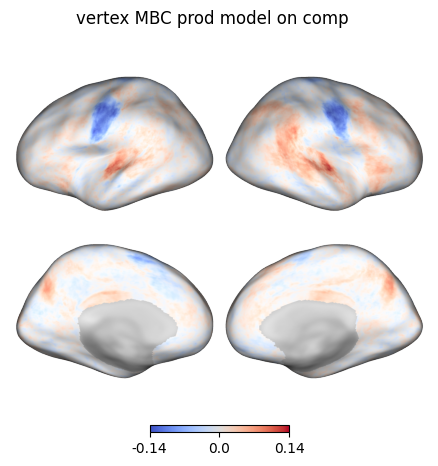

In [13]:
mx = 0.14
p = plot.get_surfplot()
p.add_layer(scores_prod, cmap="coolwarm", color_range=(-mx, mx))
# p.add_layer(scores_prod, cmap='magma', color_range=(0, mx))
fig = p.build()
fig.suptitle("vertex MBC prod model on comp")
fig.show()

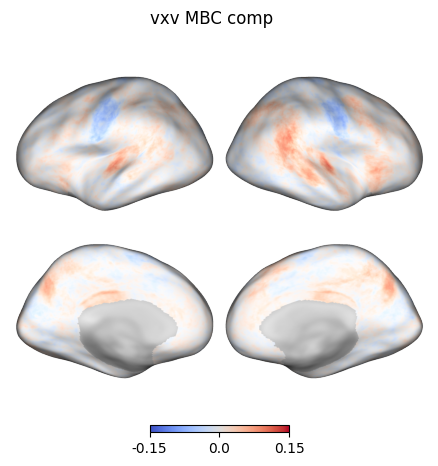

In [29]:
p = plot.get_surfplot()
p.add_layer(scores_comp, cmap="coolwarm", color_range=(-0.15, 0.15))
# p.add_layer(np.abs(scores_comp), cmap="magma", color_range=(-0, 0.15))
fig = p.build()
fig.suptitle("vxv MBC comp")
fig.show()

# Atlases

In [149]:
atlas = Atlas.glasser2016()

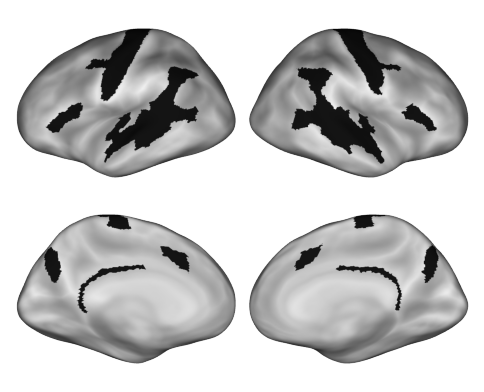

In [197]:
rois = ['L_POS2_ROI']
rois += ['L_3b_ROI', 'L_3a_ROI', 'L_4_ROI']
rois += ['L_44_ROI', 'L_45_ROI'] #, 'L_47l_ROI', 'L_a47r_ROI']
rois += ['L_55b_ROI']

rois += ['L_STSda_ROI', 'L_STSdp_ROI', 'L_STSvp_ROI']
rois += ['L_A1_ROI', 'L_A4_ROI', 'L_A5_ROI']
rois += ['L_PBelt_ROI', 'L_MBelt_ROI']

rois += ['L_PFm_ROI']
rois += ['L_TPOJ1_ROI', 'L_TPOJ2_ROI'] #, 'L_TPOJ3_ROI']
rois += ['L_PSL_ROI']
rois += ['L_STV_ROI']

rois += ['L_RSC_ROI']
rois += ['L_p32pr_ROI']


# PF?

rois = rois + [r.replace('L_', 'R_') for r in rois]

mask = roimask(atlas, rois)
fig = plot.surface_plot(mask.astype(np.int8), cmap='gray_r', cbar=False)

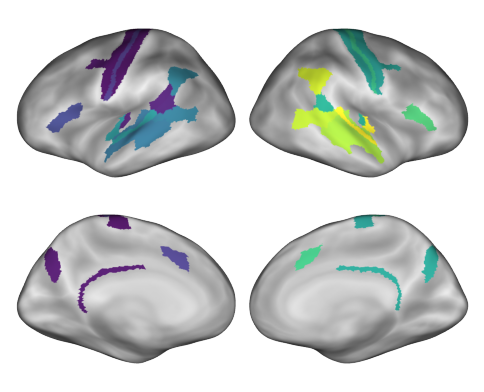

In [203]:
roi_img = np.where(mask, atlas.label_img, 0)
fig = plot.surface_plot(roi_img, cmap='viridis', cbar=False, vmin=0, vmax=360)

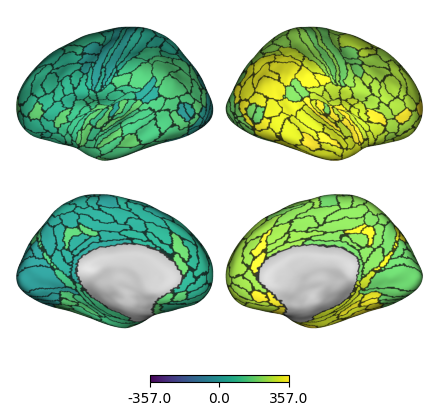

In [204]:
fig = plot.surface_plot(atlas.label_img, cmap='viridis', atlas=atlas)

In [5]:
region_numbers = [51]  # , 53, 9, 8, 54, 56, 78]
for i in region_numbers:
    print(id2label[i])
regions = np.where(np.isin(parc_mask, region_numbers), parc_mask, 0)
regions.shape, regions.sum()

L_1_ROI


((81924,), 53295)

In [191]:
prod_roi_mask = regions != 0

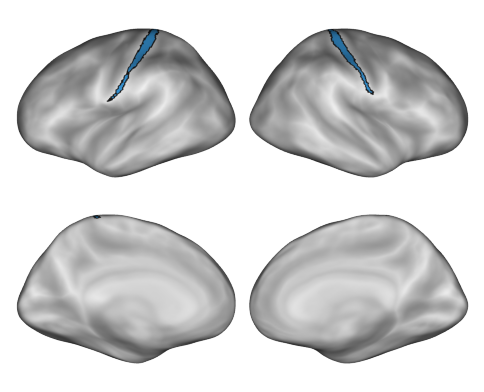

In [6]:
p = plot.get_surfplot()
p.add_layer(regions, cmap="tab10", cbar=False)
p.add_layer(regions, cmap="gray", as_outline=True, cbar=False)
fig = p.build()

In [17]:
del id2label[0]

In [18]:
label2id = {l.lstrip("L_").rstrip("_ROI"): i for i, l in id2label.items()}

In [19]:
rois = ["1", "3a", "3b", "4", "6d", "6v", "6r"]
for roi in rois:
    print(roi, label2id[roi])

1 51
3a 53
3b 9
4 8
6d 54
6v 56
6r 78


In [20]:
!mkdir -p figures/glasser-rois

In [21]:
for label, i in label2id.items():
    regions = parc_mask == i
    p = plot.get_surfplot(size=(800, 200), zoom=1.2, layout="row")
    p.add_layer(regions, cmap="tab10", cbar=False)
    p.add_layer(regions, cmap="gray", as_outline=True, cbar=False)
    fig = p.build()
    fig.supylabel(f"{i}:{label}", rotation=0)
    fig.savefig(f"figures/glasser-rois/{label}-{i:03d}.png")
    plt.close()
plt.close()

# surface gradients

In [13]:
from neuromaps.transforms import mni152_to_fsaverage

In [99]:
def get_surf_grad(kind: str = 'transverse', vmin: float = 0.0, vmax: float = 1.0) -> np.ndarray:
    """Get a gradient in fsaverage space.
    # coronal: inferior - superior
    # transverse: posterior - anterior
    # saggital: lateral - medial
    """
    gradimg = np.zeros((91, 109, 91), dtype=np.float32)

    # post-ant
    if kind == 'transverse':
        grad = np.linspace(vmin, vmax, 109, dtype=gradimg.dtype)
        for i, j in np.ndindex(91, 91):
            gradimg[i, :, j] = grad
    # ventral-dorsal
    elif kind == 'coronal':
        grad = np.linspace(vmin, vmax, 91, dtype=gradimg.dtype)
        for i, j in np.ndindex(91, 109):
            gradimg[i, j, :] = grad
    elif kind == 'saggital':
        grad = np.linspace(vmin, vmax, 91, dtype=gradimg.dtype)
        for i, j in np.ndindex(109, 91):
            gradimg[:, i, j] = grad

    affine = np.array([[  -2.,    0.,    0.,   90.],
                    [   0.,    2.,    0., -126.],
                    [   0.,    0.,    2.,  -72.],
                    [   0.,    0.,    0.,    1.]])
    new_nimg = nib.nifti1.Nifti1Image(gradimg, affine=affine)

    gifL, gifR = mni152_to_fsaverage(new_nimg, method='linear')
    fs_grad = np.concatenate((gifL.agg_data(), gifR.agg_data()))
    return fs_grad

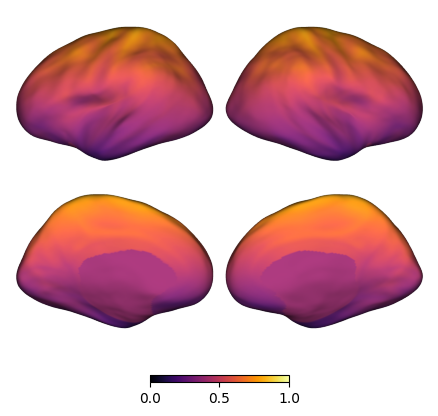

In [101]:
fs_grad = get_surf_grad('coronal')
fig = plot.surface_plot(fs_grad, vmin=0, vmax=1, cmap='inferno');

## lang atlas

In [103]:
from neuromaps.transforms import mni152_to_fsaverage

gifL, gifR = mni152_to_fsaverage('mats/allParcels_language_SN220.nii', method='nearest')
lang_atlas = np.concatenate((gifL.agg_data(), gifR.agg_data()))

labels = ["???", "LH_IFGorb", "LH_IFG", "LH_MFG", "LH_AntTemp", "LH_PostTemp", "LH_AngG", "RH_IFGorb", "RH_IFG", "RH_MFG", "RH_AntTemp", "RH_PostTemp", "RH_AngG",]
label2id = {label: i for i, label in enumerate(labels)}

langat = Atlas('langnet', lang_atlas, label2id)

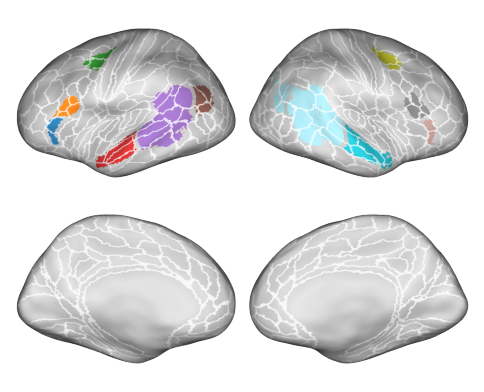

In [106]:
all_mask = lang_atlas
fig = plot.surface_plot(all_mask, atlas=glasser, vmin=1, cmap='tab20', cbar=False, sulc_alpha=0.2) #, **fslr_params)

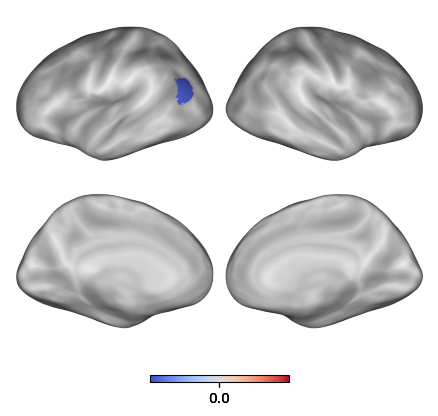

In [21]:
fig = plot.surface_plot((lang_atlas == label2id['LH_AngG']).astype(np.int32), sulc_alpha=0.5)

In [26]:
label2id['LH_AngG']

6

In [74]:
glasser = Atlas.glasser2016()

In [34]:
for i, label in enumerate(labels[1:7], 1):
    ids, counts = np.unique(glasser.label_img[lang_atlas == i], return_counts=True)
    sortids = counts.argsort()[::-1]
    print(label, i)
    print(ids[sortids])
    print(counts[sortids])
    print()

LH_IFGorb 1
[ 75  76  82  66 171  77]
[113  79   8   5   3   2]

LH_IFG 2
[74 81 79 75 82]
[101  75  52  40  19]

LH_MFG 3
[12 10 67 11 54 97  8]
[121 108  31  17  15   6   1]

LH_AntTemp 4
[176 128 132 125 131 123 129 130 177 134]
[171 159  95  67  60  53  23  14   4   1]

LH_PostTemp 5
[150 130 139 129  28  25 137 133 140 149 125 148 177 175 157 105]
[234 225 212 200 166 160 146 145  94  64  53  19  13  13   8   7]

LH_AngG 6
[151 150 141 143 140   2  23]
[139 130  82  25  16   8   2]



In [145]:
# rois = {
#     'LH_EarlyAud': ['L_A1_ROI', 'L_A4_ROI', 'L_A5_ROI', 'L_LBelt_ROI', 'L_PBelt_ROI', 'L_MBelt_ROI'],
#     'LH_PostTemp': [150, 130, 139, 129,  28,  25, 137, 133, 140, 149, 125, 148, 177, 175, 157, 105,],
#     'LH_AntTemp': [176, 128, 132],
#     'LH_MFG': [12, 10],
#     'LH_AngG': [151, 141, 143, 140,   2,  23],
#     'LH_IFG': [74],
#     'LH_IFGorb': [75, 76],
#     'LH_PreCun': ['L_POS2_ROI'],
# }

# from LanAtlas paper SI-I fig
rois = {
    'LH_SM': [f'L_{l}_ROI' for l in ['3b', '3a', '4']],
    'LH_EarlyAud': ['L_A1_ROI', 'L_A4_ROI', 'L_LBelt_ROI', 'L_PBelt_ROI', 'L_MBelt_ROI'],
    'LH_AntTemp': [f'L_{l}_ROI' for l in ['TA2', 'STSva', 'STSda', 'STGa', 'Pl', 'A5']],
    'LH_PostTemp': [f'L_{l}_ROI' for l in ['TPOJ1', 'TPOJ2', 'STV', 'STSvp', 'STSdp', 'PSL', 'PHT', 'PGi']],
    'LH_MFG': [f'L_{l}_ROI' for l in ['FEF', '55b']],
    'LH_IFG': [f'L_{l}_ROI' for l in ['IFSp', 'IFJa', '44']],
    'LH_IFGorb': [f'L_{l}_ROI' for l in ['47l', '45']],
    'LH_AngG': [f'L_{l}_ROI' for l in ['TPOJ3', 'PGs']],
    'LH_PMC': [f'L_{l}_ROI' for l in ['31a', '31pd', '31pv']],
    'LH_PreCun': ['L_POS2_ROI'],
}
flip = lambda x: ['R' + r[1:] for r in x]
rois |= {k.replace('LH_', 'RH_') : flip(v) for k, v in rois.items()}

In [146]:
label_img = np.zeros_like(glasser.label_img)
labels = {0: '???'}
for i, (k, v) in enumerate(rois.items(), 1):
    mask = glasser.roimask(v)
    print(i, k, v, mask.sum())
    label_img[mask] = i# % 10
    labels[i] = k
custom_atlas = Atlas('custom', label_img, labels)

1 LH_SM ['L_3b_ROI', 'L_3a_ROI', 'L_4_ROI'] 2166
2 LH_EarlyAud ['L_A1_ROI', 'L_A4_ROI', 'L_LBelt_ROI', 'L_PBelt_ROI', 'L_MBelt_ROI'] 818
3 LH_AntTemp ['L_TA2_ROI', 'L_STSva_ROI', 'L_STSda_ROI', 'L_STGa_ROI', 'L_Pl_ROI', 'L_A5_ROI'] 681
4 LH_PostTemp ['L_TPOJ1_ROI', 'L_TPOJ2_ROI', 'L_STV_ROI', 'L_STSvp_ROI', 'L_STSdp_ROI', 'L_PSL_ROI', 'L_PHT_ROI', 'L_PGi_ROI'] 1905
5 LH_MFG ['L_FEF_ROI', 'L_55b_ROI'] 371
6 LH_IFG ['L_IFSp_ROI', 'L_IFJa_ROI', 'L_44_ROI'] 442
7 LH_IFGorb ['L_47l_ROI', 'L_45_ROI'] 399
8 LH_AngG ['L_TPOJ3_ROI', 'L_PGs_ROI'] 430
9 LH_PMC ['L_31a_ROI', 'L_31pd_ROI', 'L_31pv_ROI'] 350
10 LH_PreCun ['L_POS2_ROI'] 302
11 RH_SM ['R_3b_ROI', 'R_3a_ROI', 'R_4_ROI'] 2050
12 RH_EarlyAud ['R_A1_ROI', 'R_A4_ROI', 'R_LBelt_ROI', 'R_PBelt_ROI', 'R_MBelt_ROI'] 643
13 RH_AntTemp ['R_TA2_ROI', 'R_STSva_ROI', 'R_STSda_ROI', 'R_STGa_ROI', 'R_Pl_ROI', 'R_A5_ROI'] 795
14 RH_PostTemp ['R_TPOJ1_ROI', 'R_TPOJ2_ROI', 'R_STV_ROI', 'R_STSvp_ROI', 'R_STSdp_ROI', 'R_PSL_ROI', 'R_PHT_ROI', 'R_PGi_ROI']

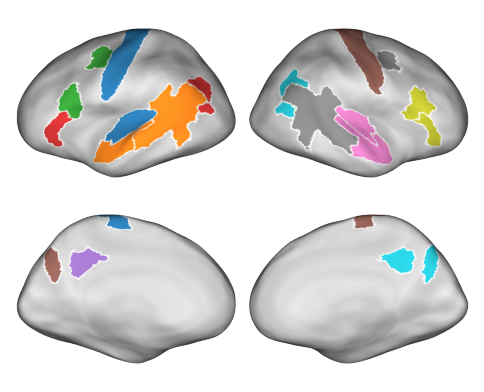

In [147]:
# all_mask = (label_img > 0).astype(np.int32)
all_mask = label_img
fig = plot.surface_plot(all_mask, atlas=custom_atlas, vmin=1, cmap='tab10', cbar=False, sulc_alpha=0.2) #, **fslr_params)

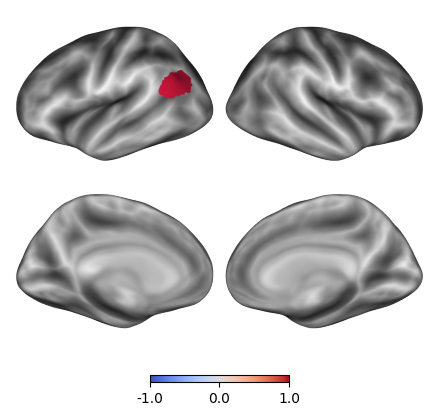

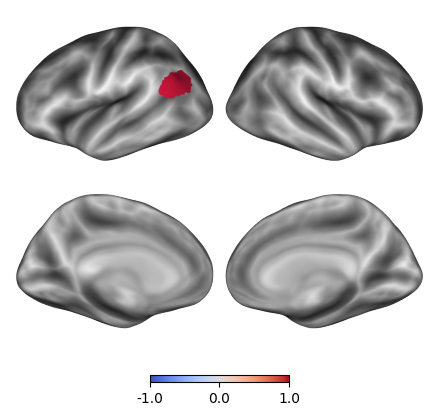

In [32]:
plot.surface_plot(np.in1d(glasser.label_img, [151, 150]).astype(int))

# 'story' encoding

In [2]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

In [3]:
subs = list(CONVS_STRANGERS) + [c - 100 for c in CONVS_STRANGERS]
# these subjects didn't do listen to this story, not sure why
subs.remove(11)
subs.remove(111)
subs.remove(12)

In [4]:
import torch
from sklearn.preprocessing import StandardScaler
from voxelwise_tutorials.delayer import Delayer
from sklearn.model_selection import KFold
from himalaya.kernel_ridge import KernelRidgeCV
from sklearn.pipeline import make_pipeline
from himalaya.scoring import correlation_score
from himalaya.backend import set_backend

In [5]:
# Function to average embeddings per TR
def construct_predictors(transcript_df, n_features, stim_dur, tr=1.5):
    # Find total number of TRs
    stim_trs = np.ceil(stim_dur / tr)

    # Add column to transcript with TR indices
    transcript_df["TR"] = transcript_df.onset.divide(tr).apply(np.floor).apply(int)

    # Compile the words within each TR
    words_per_tr = transcript_df.groupby("TR")["word"].apply(list)

    # Average the embeddings within each TR
    embeddings_per_tr = transcript_df.groupby("TR")["embedding"].mean()

    # Loop through TRs
    words_trs = []
    embeddings_trs = []
    for t in np.arange(stim_trs):
        if t in words_per_tr:
            words_trs.append(words_per_tr[t])

            # Fill in empty TRs with zero vectors
            if embeddings_per_tr[t] is not np.nan:
                embeddings_trs.append(embeddings_per_tr[t])
            else:
                embeddings_trs.append(np.zeros(n_features))
        else:
            words_trs.append([])
            embeddings_trs.append(np.zeros(n_features))

    embeddings = np.vstack(embeddings_trs)
    return embeddings

In [8]:
# Reload transcript with embeddings if already generated
transcript_f = "black_gpt2.pkl"
with open(transcript_f, "rb") as f:
    transcript_gpt2 = pickle.load(f)

In [9]:
# GPT-2 embeddings are 768-dimensional
X = construct_predictors(transcript_gpt2, 768, 800, tr=1.5)
X.shape

(534, 768)

In [10]:
# Split-half outer and inner cross-validation
outer_cv = KFold(n_splits=2)
inner_cv = KFold(n_splits=5)

# Mean-center each feature (columns of predictor matrix)
scaler = StandardScaler(with_mean=True, with_std=True)

# Create delays at 3, 4.5, 6, 7.5 seconds (1.5 s TR)
delayer = Delayer(delays=[2, 3, 4, 5])

# Ridge regression with alpha grid and nested CV
alphas = np.logspace(1, 10, 10)
ridge = KernelRidgeCV(alphas=alphas, cv=inner_cv)

# Chain transfroms and estimator into pipeline
pipeline = make_pipeline(scaler, delayer, ridge)

In [11]:
set_backend("torch")

<module 'himalaya.backend.torch' from '/scratch/gpfs/zzada/conda-envs/fconv/lib/python3.11/site-packages/himalaya/backend/torch.py'>

In [12]:
start_trs = 8
end_trs = 8
results = []

for sub in tqdm(subs):
    boldpath = Path(
        root="data/derivatives/fmriprep/",
        datatype="func",
        sub="004",
        ses=1,
        task="Black",
        run=1,
        space="fsaverage6",
        hemi="L",
        suffix="bold",
        ext=".func.gii",
    )
    boldpath.update(sub=f"{sub:03d}")
    paths = [boldpath, boldpath.copy().update(hemi="R")]

    confpath = Path(
        root="data/derivatives/fmriprep/",
        sub="004",
        ses=1,
        datatype="func",
        task="Black",
        run=1,
        desc="confounds",
        suffix="timeseries",
        ext=".tsv",
    )
    confpath.update(sub=f"{sub:03d}")

    confdata = pd.read_csv(confpath, sep="\t", usecols=CONFOUNDS)
    confdata.bfill(inplace=True)

    masker = subject.GiftiMasker(
        t_r=TR,
        ensure_finite=True,
        standardize="zscore_sample",
        standardize_confounds=True,
    )
    Y_bold = masker.fit_transform(paths, confounds=confdata.to_numpy())
    Y_bold = Y_bold[start_trs:-end_trs]

    # Loop through outer folds and estimate model
    Y_predicted = []
    for train, test in outer_cv.split(Y_bold):
        # Fit pipeline with transforms and ridge estimator
        pipeline.fit(X[train], Y_bold[train])

        # Compute predicted response
        predicted = pipeline.predict(X[test])
        Y_predicted.append(predicted)

    # Restack first and second half predictions
    Y_predicted = torch.vstack(Y_predicted)
    score_parcels = correlation_score(Y_bold, Y_predicted).numpy(force=True)

    results.append({"scores": score_parcels})

100%|██████████| 55/55 [15:06<00:00, 16.48s/it]


In [13]:
story_scores = np.vstack([r["scores"] for r in results])
# np.savez('storyscores.npz', story_scores)
story_scores.shape

(55, 81924)

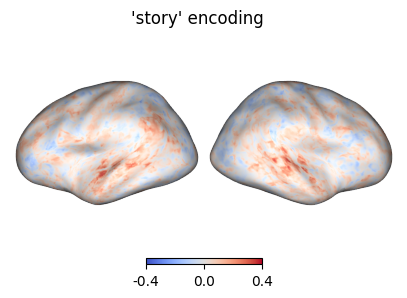

In [31]:
p = plot.get_surfplot(views="lateral", size=(400, 200), zoom=1.2)
p.add_layer(results[6]["scores"], cmap="coolwarm", color_range=(-0.4, 0.4))
fig = p.build()
fig.suptitle("'story' encoding")
fig.show()

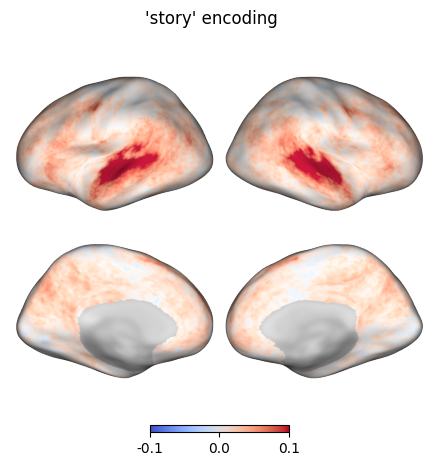

In [16]:
values = np.mean(story_scores, axis=0)
# values = black_scores[0]
# mx = max(np.abs(values.min()), values.max())

p = plot.get_surfplot()
p.add_layer(values, cmap="coolwarm", color_range=(-0.1, 0.1))
fig = p.build()
fig.suptitle("'story' encoding")
fig.show()

# pycortex

In [3]:
import cortex
# from neuromaps.transforms import fsaverage_to_fsaverage
# cortex.utils.download_subject(subject_id='fsaverage', download_again=True)

In [10]:
vert = cortex.Vertex(np.ones(327684), 'fsaverage')

/scratch/gpfs/zzada/conda-envs/fconv/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: divide by zero encountered in buffer
  return lib.buffer(


Setting _INKSCAPE_GC=disable as a workaround for broken libgc
Unable to init server: Could not connect: Connection refused
(ld-linux-x86-64.so.2:737559): glibmm-WARNING **: 21:27:34.905: Failed to wrap object of type 'GtkRecentManager'. Hint: this error is commonly caused by failing to call a library init() function.


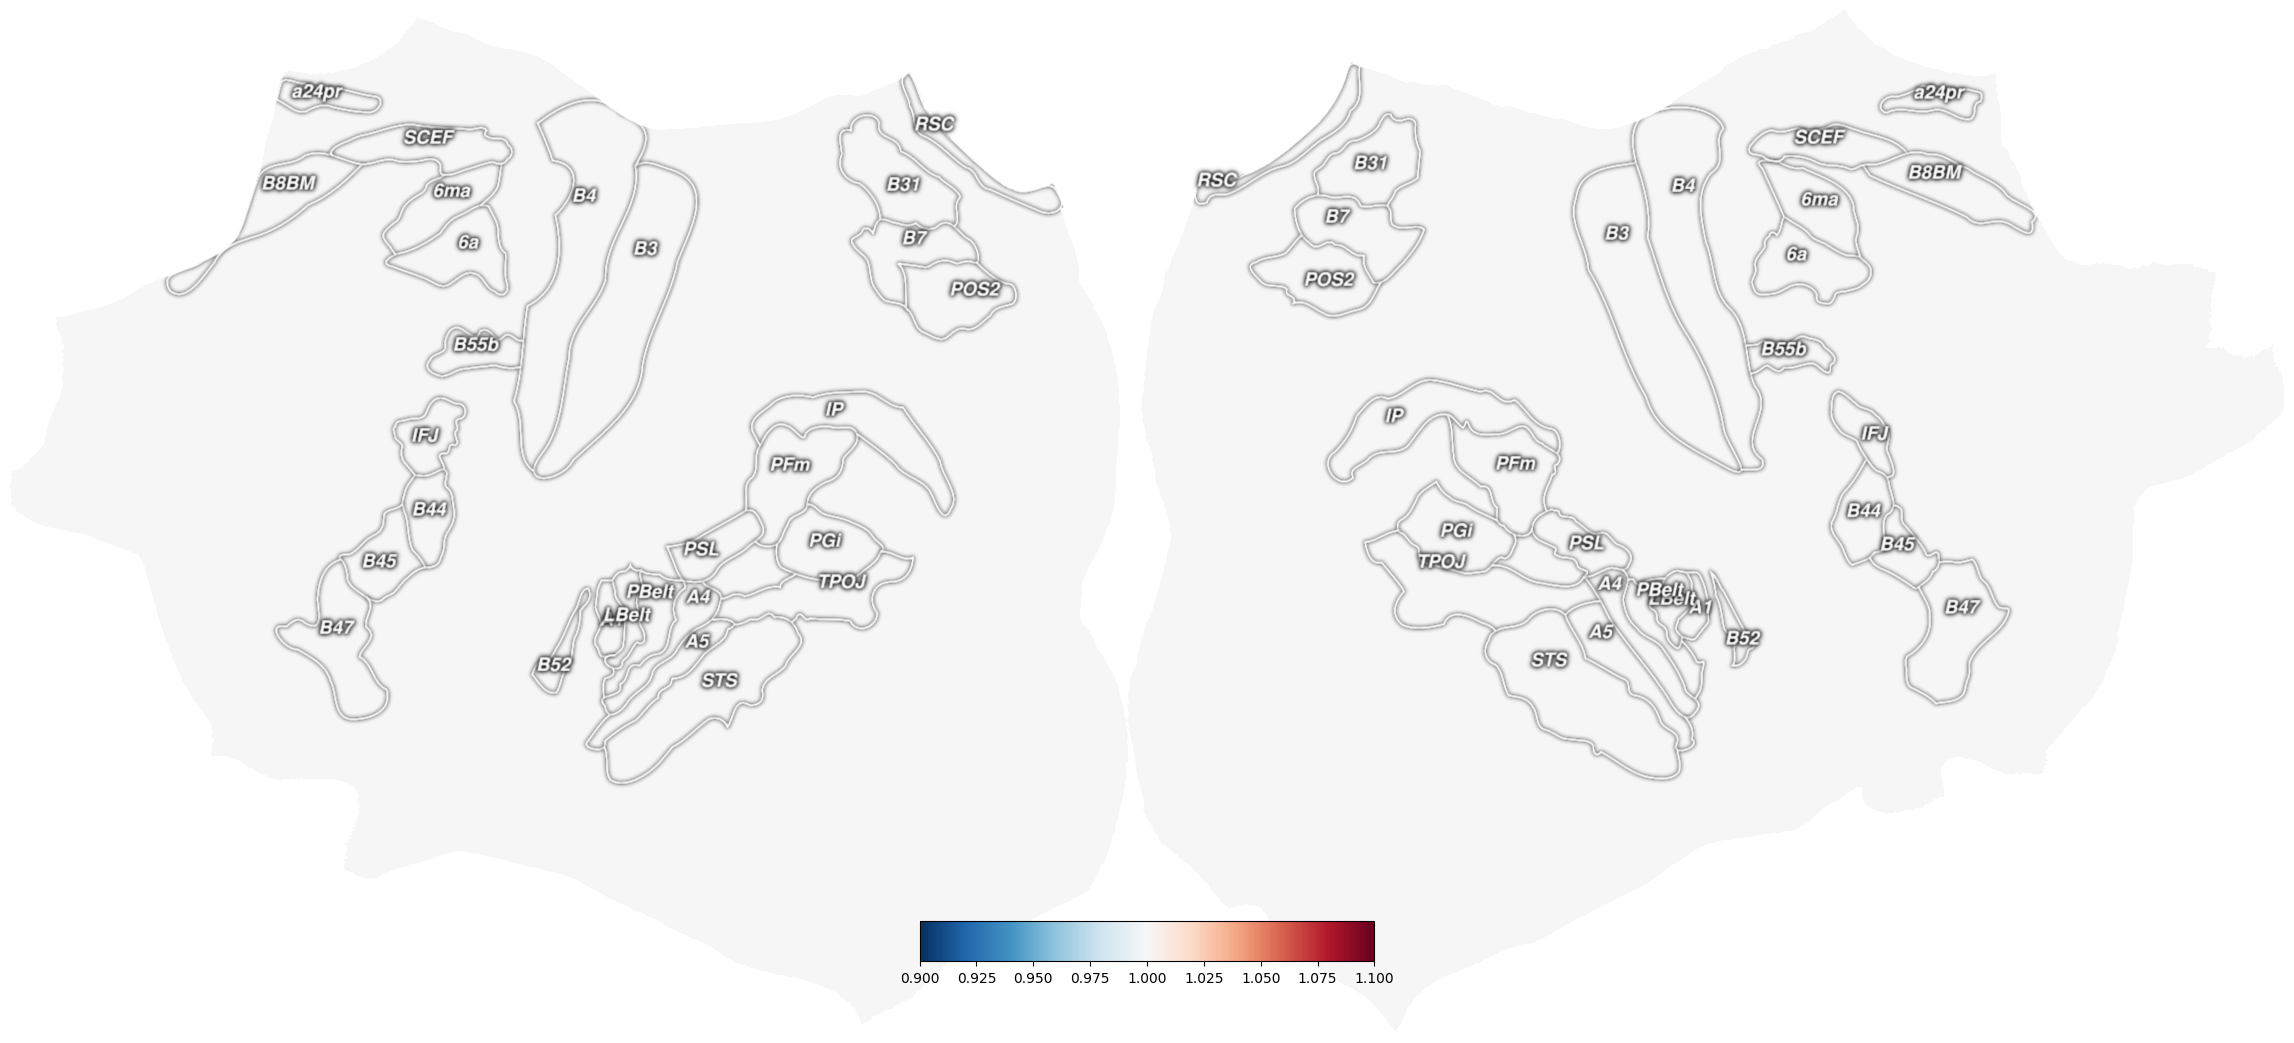

In [11]:
fig = cortex.quickflat.make_figure(vert)
fig.show()

In [4]:
glasser = Atlas.glasser2016()

In [ ]:
# glasser atlas
rois = [
    # motor
    ("3", ("3a", "3b")),
    "4",
    ("6", ("6a", "6ma")),
    ("7", ("7m", "7Pm")),
    "8BM",
    ("31", ("31a", "31pd", "31pv")),
    # ifg
    "44",
    "45",
    ("47", ("47l", "47m", "47s")),
    "52",
    "55b",
    "PSL",
    "RSC",
    "SCEF",
    "SFL",
    "A4",
    "A5",
    "a24pr",
    "AVI",
    "PCV",
    "PEF",
    "PFm",
    "PGi",
    ("PoI", ("PoI1", "PoI2")),
    "FEF",
    "FOP5",
    ("ifj", ("IFJa", "IFJp")),
    ("ip", ("IP0", "IP1", "IP2")),
    ("sts", ("STSda", "STSdp", "STSva", "STSvp")),
    "STV",
    "RI",
    "A1",
    "LBelt",
    "PBelt",
    ("tpoj", ("TPOJ1", "TPOJ2", "TPOJ3")),
    ("POS2")
    # 8C? 46? a32pr? d32? LIPd? OP4?
]

In [6]:
glasser_atlas = glasser.label_img

174

In [ ]:
for label in rois:
    if isinstance(label, str):
        verts = np.where(glasser_atlas == glasser[label], glasser_atlas, 0)
    else:
        label, labels = label
        roi_ids = np.array([label2id[roi] for roi in labels])
        verts = np.where(np.in1d(glasser_atlas, roi_ids), glasser_atlas, 0)
    roi_vertices = cortex.Vertex(verts, "fsaverage")
    print(label)
    cortex.add_roi(roi_vertices, name=f"G-{label}")

In [7]:
!cp mats/fsaverage-overlays-glasser.svg /scratch/gpfs/zzada/conda-envs/fconv/share/pycortex/db/fsaverage/overlays.svg
# !cp /scratch/gpfs/zzada/conda-envs/fconv/share/pycortex/db/fsaverage/overlays.svg mats/fsaverage-overlays-glasser.svg

In [ ]:
# save flatmap for each ROI
!mkdir -p figures/flatmaps/glasser

# roi_ids = np.array([label2id[roi] for roi in rois])
# 'FOP1', 'FOP2', 'FOP3', 'FOP4', 'FOP5'
for label, id in label2id.items():
    verts = np.where(glasser_atlas == id, glasser_atlas, 0)
    roi_vertices = cortex.Vertex(verts, 'fsaverage')
    fn = f'figures/flatmaps/glasser/{label}-{id:03d}.png'
    cortex.quickflat.make_png(fn, roi_vertices, height=960)

# test delayer

In [5]:
import torch
from voxelwise_tutorials.delayer import Delayer

In [8]:
a = np.arange(10).reshape(-1, 2)
a
b = Delayer(delays=[0, 1, 2]).fit_transform(a)
b

array([[0, 1, 0, 0, 0, 0],
       [2, 3, 0, 1, 0, 0],
       [4, 5, 2, 3, 0, 1],
       [6, 7, 4, 5, 2, 3],
       [8, 9, 6, 7, 4, 5]])

In [9]:
b.reshape(5, 3, 2).mean(1)

array([[0.        , 0.33333333],
       [0.66666667, 1.33333333],
       [2.        , 3.        ],
       [4.        , 5.        ],
       [6.        , 7.        ]])

In [10]:
# test delayer delays reshape
c = np.stack(np.split(b, 3, axis=1))
print(c.shape)
c.mean(0)

(3, 5, 2)


array([[0.        , 0.33333333],
       [0.66666667, 1.33333333],
       [2.        , 3.        ],
       [4.        , 5.        ],
       [6.        , 7.        ]])

# llm embs

In [4]:
df = pd.read_csv('mats/Conv_postscan_6.9.23.csv', index_col=1)
df

Unnamed: 0     Group  Q4_1  Q4_2  Q4_3  Q4_4  Q5_1  Q5_2  Q5_3  Q5_4  \
ID                                                                          
101           3  Stranger     5     6     3     3     5     6     6     6   
3             4    Friend     7     7     5     2     6     7     7     6   
103           5    Friend     6     7     3     1     6     7     6     7   
4             6  Stranger     4     5     6     5     5     6     6     6   
104           7  Stranger     3     3     5     4     5     4     6     7   
..          ...       ...   ...   ...   ...   ...   ...   ...   ...   ...   
73          122    Friend     3     4     5     1     5     5     5     6   
174         123  Stranger     6     6     5     3     6     6     6     6   
74          124  Stranger     4     6     3     1     4     6     6     6   
75          125    Friend     6     6     6     2     6     6     6     6   
175         126    Friend     3     5     6     2     3     5     6     2   

     ...               Q36    Q37    Q38    Q39            Q40  Q41  Q42_1  \
ID   ...                                                                     
101  ...  All of the above   TRUE  FALSE  FALSE  Embarrassment   No    4.0   
3    ...               NaN    NaN    NaN    NaN            NaN  NaN    4.0   
103  ...       “enlighten”  FALSE  FALSE  FALSE  Embarrassment  Yes    5.0   
4    ...         “educate”  FALSE  FALSE  FALSE          Pride  Yes    4.0   
104  ...  All of the above  FALSE  FALSE  FALSE          Pride  Yes    4.0   
..   ...               ...    ...    ...    ...            ...  ...    ...   
73   ...  All of the above  FALSE  FALSE  FALSE          Anger  Yes    3.0   
174  ...  All of the above  FALSE  FALSE   TRUE          Pride   No    4.0   
74   ...         “educate”  FALSE  FALSE  FALSE          Pride  Yes    5.0   
75   ...  All of the above  FALSE  FALSE  FALSE          Pride   No    3.0   
175  ...  All of the above  FALSE  FALSE  FALSE          Pride  Yes    4.0   

     Q43_1  Q44_1  Q45_1  
ID                        
101    4.0    2.0    4.0  
3      5.0    2.0    4.0  
103    4.0    3.0    5.0  
4      5.0    3.0    5.0  
104    5.0    4.0    4.0  
..     ...    ...    ...  
73     5.0    2.0    5.0  
174    4.0    2.0    4.0  
74     4.0    2.0    4.0  
75     4.0    2.0    3.0  
175    4.0    3.0    3.0  

[123 rows x 264 columns]

In [5]:
# run    01          02          03          04          05
# trial  01 02 03 04 01 02 03 04 01 02 03 04 01 02 03 04 01 02 03 04
# prompt 01 02 03 04 05 06 07 08 09 10 11 12 13 14 15 16 17 18 19 20
# prompt = 4 * (run - 1) + trial

In [6]:
items = {
'%d_Q11_1': 'speak_close',
'%d_Q11_2': 'speak_enjoy',
'%d_Q11_3': 'speak_uncertain',
'%d_Q11_4': 'speak_anxious',
'%d_Q12_1': 'listen_close',
'%d_Q12_2': 'listen_enjoy',
'%d_Q12_3': 'listen_learned',
'%d_Q12_4': 'listen_paidattention',
}

In [22]:
records = []
for sub in SUBS_STRANGERS:
    gen_trials = subject.get_trials(sub)
    for run in RUNS:
        for trial in gen_trials[run]:
            prompt = 4*(run-1) + trial
            for item, label in items.items():
                col = item % prompt
                records.append((sub, run, trial, prompt, label, df.loc[sub, col]))
df2 = pd.DataFrame(records, columns=['subject', 'run', 'trial', 'prompt', 'label', 'rating'])
df2.shape

(4640, 6)

In [25]:
df3 = df2.groupby(['subject', 'run', 'trial', 'label']).rating.mean().reset_index()
df3

subject  run  trial                 label  rating
0           4    1      1          listen_close     1.0
1           4    1      1          listen_enjoy     1.0
2           4    1      1        listen_learned     1.0
3           4    1      1  listen_paidattention     1.0
4           4    1      1         speak_anxious     4.0
...       ...  ...    ...                   ...     ...
4635      174    5      4  listen_paidattention     5.0
4636      174    5      4         speak_anxious     4.0
4637      174    5      4           speak_close     4.0
4638      174    5      4           speak_enjoy     5.0
4639      174    5      4       speak_uncertain     4.0

[4640 rows x 5 columns]

In [26]:
df3.to_csv('mats/conv_postscan_run.csv')

/scratch/gpfs/zzada/conda-envs/fconv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/gpfs/zzada/conda-envs/fconv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/gpfs/zzada/conda-envs/fconv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='label', ylabel='rating'>

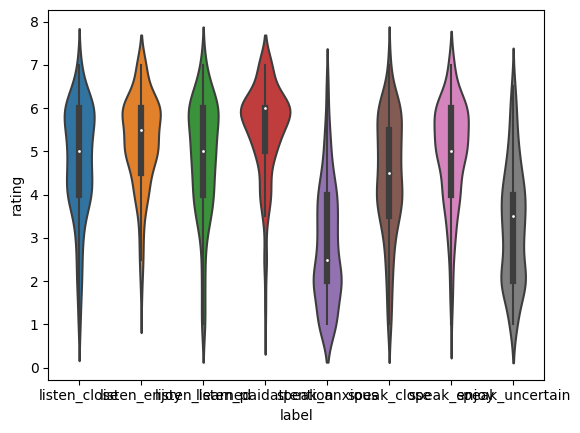

In [18]:
sns.violinplot(data=df2, x='label', y='rating', )

In [224]:
dfs = []
for sub in SUBS_STRANGERS:
    df = subject.get_transcript(sub, modelname=modelname)
    dfs.append(df.groupby(['run', 'trial', 'speaker'])[['entropy', 'true_prob']].mean().reset_index())
df = pd.concat(dfs)
df

run  trial  speaker   entropy  true_prob
0     1      1        4  3.407635   0.192351
1     1      1      104  3.523010   0.224309
2     1      4        4  3.082306   0.258254
3     1      4      104  3.480963   0.209883
4     2      6        4  3.216275   0.238834
..  ...    ...      ...       ...        ...
15    4     15      174  2.668504   0.307220
16    5     18       74  3.130756   0.238659
17    5     18      174  2.929116   0.263451
18    5     20       74  3.027314   0.216626
19    5     20      174  3.084847   0.259216

[1156 rows x 5 columns]

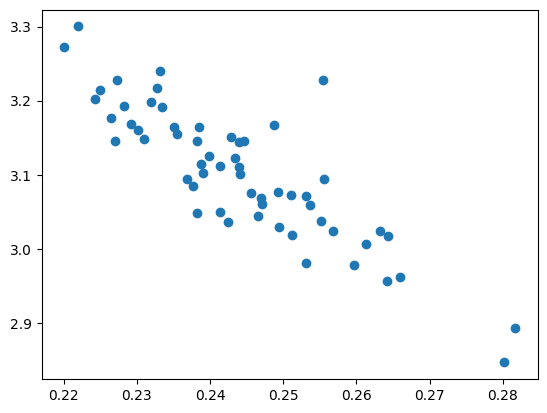

In [260]:
# variability amongst speakers
df2 = df.groupby('speaker').mean()
plt.scatter(df2.true_prob, df2.entropy)

In [256]:
# partners are more similar to each other?
df2 = df.sort_values('speaker').reset_index(drop=True)
half = len(df2) // 2
print(pearsonr(df2[:half].entropy.values, df2[half:].entropy.values))
print(pearsonr(df2[:half].true_prob.values, df2[half:].true_prob.values))

PearsonRResult(statistic=0.110323396879869, pvalue=0.00793741619064092)
PearsonRResult(statistic=0.08380403175866681, pvalue=0.04401290804400114)


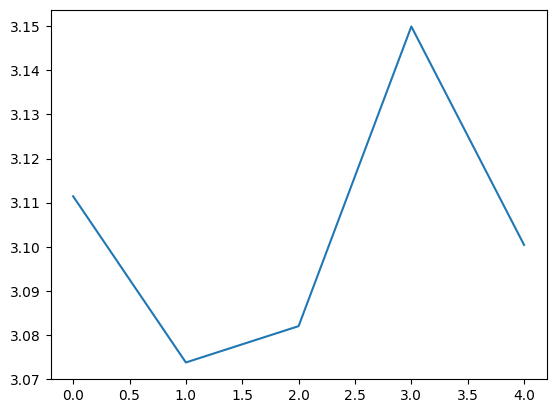

In [259]:
# are there changes across trials and runs as prompts get more personal?
plt.plot(df.groupby('run').entropy.mean().values)
# plt.plot(df.groupby('run').true_prob.mean().values)